In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import anndata as ad
import os
import scanpy as sc
from statsmodels.stats.multitest import multipletests
import sys
sys.path.append("../src")
from evaluation_metrics import *
from utils_evaluation import *

/data_nfs/je30bery/rosenbaum_test/notebooks/../src/utils_evaluation.py:90: SyntaxWarning: invalid escape sequence '\m'
  "scXMatch": "$\mathbf{scXMatch}$",
/data_nfs/je30bery/rosenbaum_test/notebooks/../src/utils_evaluation.py:154: SyntaxWarning: invalid escape sequence '\m'
  "scXMatch": "$\mathbf{scXMatch}$",
/data_nfs/je30bery/rosenbaum_test/notebooks/../src/utils_evaluation.py:206: SyntaxWarning: invalid escape sequence '\m'
  "scXMatch": "$\mathbf{scXMatch}$",


In [27]:
from statsmodels.stats.multitest import multipletests

In [4]:
bm_results_dfs, mon_df, melted_mon = get_mon_df()
ssnr_results_dfs, ssnr_df, melted_ssnr = get_ssnr_df(bm_results_dfs)
var_results_dfs, var_df, melted_var = get_sv_df()

/data_nfs/je30bery/rosenbaum_test/notebooks/../src/utils_evaluation.py:170: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  xm_results_dfs_var[dataset].replace({"split_10": 10, "split_30": 30, "split_50": 50}, inplace=True)
/data_nfs/je30bery/rosenbaum_test/notebooks/../src/utils_evaluation.py:170: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  xm_results_dfs_var[dataset].replace({"split_10": 10, "split_30": 30, "split_50": 50}, inplace=True)
/data_nfs/je30bery/rosenbaum_test/notebooks/../src/utils_evaluation.py:170: FutureWarning: D

array(['mcfarland', 'norman', 'schiebinger', 'sciplex_A549',
       'sciplex_K562', 'sciplex_MCF7', 'bhattacherjee_excitatory'],
      dtype=object)

In [21]:
FPR = np.sum(ssnr_results_dfs.drop(["bhattacherjee_excitatory"])["scXMatch"] >= 0.95) / len(ssnr_results_dfs.drop(["bhattacherjee_excitatory"]))
FPR

In [53]:
FPR_adj = 0
total_len = 0
for dataset in melted_ssnr["dataset"].unique():
    if "bhattacherjee" in dataset:
        continue
    for group in ssnr_results_dfs.drop(["bhattacherjee_excitatory"]).loc[dataset].reset_index()["test_group"].unique():
        p_vals = 1 - ssnr_results_dfs.drop(["bhattacherjee_excitatory"]).loc[(dataset, group)]["scXMatch"].values
        adj_pvals = multipletests(p_vals, method="fdr_bh")[1]
        FPR_adj += np.sum(adj_pvals < 0.05)
        total_len += len(adj_pvals)
print(FPR_adj / total_len)

0.013333333333333334


/tmp/ipykernel_326102/3848712239.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_vals = 1 - ssnr_results_dfs.drop(["bhattacherjee_excitatory"]).loc[(dataset, group)]["scXMatch"].values
/tmp/ipykernel_326102/3848712239.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_vals = 1 - ssnr_results_dfs.drop(["bhattacherjee_excitatory"]).loc[(dataset, group)]["scXMatch"].values
/tmp/ipykernel_326102/3848712239.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_vals = 1 - ssnr_results_dfs.drop(["bhattacherjee_excitatory"]).loc[(dataset, group)]["scXMatch"].values
/tmp/ipykernel_326102/3848712239.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_vals = 1 - ssnr_results_dfs.drop(["bhattacherjee_excitatory"]).loc[(dataset, group)]["scXMatch"].values
/tmp/ipykernel_326102/3848712239.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  p_vals = 1 

In [18]:
for f in os.listdir("../evaluation_results/1_1_monotonicity_scxmatch/"):
    if "sciplex" in f:
        csv = pd.read_csv(os.path.join("../evaluation_results/1_1_monotonicity_scxmatch/", f))
        csv.set_index("test_group").to_excel(os.path.join("../evaluation_results/1_1_monotonicity_scxmatch/", f.replace(".txt", ".xlsx")))

In [4]:
pd.concat(bm_results_dfs).sort_index().to_excel("monotonicity.xlsx")
ssnr_results_dfs.sort_index().to_excel("ssnr.xlsx")
var_results_dfs.sort_index().to_excel("sv.xlsx")

In [5]:
pareto_counts, pareto_sets = compute_pareto_optimal_datasets(mon_df, ssnr_df, var_df)
samples = set()
for sample_list in pareto_sets.values():
    samples.update(sample_list)
heatmap_data = {method: [sample in sample_list for sample in samples] 
                for method, sample_list in pareto_sets.items()}
df = pd.DataFrame(heatmap_data, index=list(samples)).T

In [6]:
df = df.sort_index(axis=1)
df.rename({"deseq2_100": "#DEGs $DESeq2_{100}$", 
               "edgeR_100": "#DEGs $edgeR_{100}$",
              "augur": "$Augur$",
                "wilcoxon": "#DEGs $Wilcoxon$",
               "scXMatch": "$\mathbf{scXMatch}$",
               }, inplace=True, axis=0)
dummy_heatmap = np.ones([7, 5])
dummy_heatmap[:, 1] = 2
dummy_heatmap[:, 2] = 3
dummy_heatmap[:, 3] = 4
dummy_heatmap[:, 4] = 5
dummy_heatmap = pd.DataFrame(dummy_heatmap, columns=df.index, index=df.columns)
mask = df.T <= 0

In [8]:
melted_mon = melted_mon.sort_values("dataset")
melted_ssnr = melted_ssnr.sort_values("dataset")
melted_var = melted_var.sort_values("dataset")

In [10]:
palette = sns.color_palette("viridis", 4) + sns.color_palette("magma", 1)
palette_dict = {           
    '$Augur$': palette[0],
    '#DEGs $DESeq2_{100}$': palette[1],
    '#DEGs $Wilcoxon$': palette[2],
    '#DEGs $edgeR_{100}$': palette[3],
    '$\\mathbf{scXMatch}$': palette[4]}

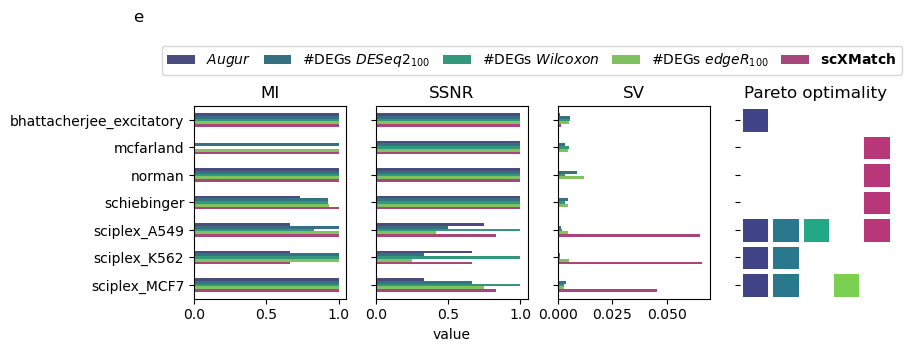

In [11]:
f, axs = plt.subplots(1, 4, figsize=(9, 2.5))

sns.barplot(melted_mon, y="dataset", hue="metric", x="value", orient="h", palette=palette_dict, ax=axs[0], legend=True, width=0.5, hue_order=palette_dict.keys())
axs[0].set_title("MI")
axs[0].set_ylabel("")
axs[0].set_xlabel("")
#axs[0].set_yticklabels(["McFarland", "Norman", "Schiebinger", "Sciplex A549", "Sciplex K562", "Sciplex MCF7"])

sns.barplot(melted_ssnr, y="dataset", hue="metric", x="value", orient="h", palette=palette_dict, ax=axs[1], legend=False, width=0.5, hue_order=palette_dict.keys())
axs[1].set_title("SSNR")
axs[1].set_ylabel("")
axs[1].set_yticklabels([])

sns.barplot(melted_var, y="dataset", hue="metric", x="value", orient="h", palette=palette_dict, ax=axs[2], legend=False, width=0.5, hue_order=palette_dict.keys())
axs[2].set_title("SV")
axs[2].set_ylabel("")
axs[2].set_xlabel("")
axs[2].set_yticklabels([])

handles, labels = axs[0].get_legend_handles_labels()
f.legend(handles, labels, loc='upper center', ncol=len(palette), bbox_to_anchor=(0.5, 1.15), columnspacing=0.9)
axs[0].legend_.remove()

axs[0].text(
    -0.4, 1.5,  # Position (normalized figure coordinates)
    "e",   # Corresponding letter
    transform=axs[0].transAxes,  # Relative to subplot
    fontsize=12, va='top', ha='left'
)

sns.heatmap(dummy_heatmap, mask=mask, linewidths=2.5, linecolor='white', ax=axs[3], cbar=False, cmap=palette)
axs[3].set_title("Pareto optimality")
axs[3].set_yticklabels([])
axs[3].set_xticklabels([])
axs[3].set_xticks([])

plt.savefig("../plots/fig3/fig3e.pdf", bbox_inches="tight")